In [ ]:
# connecting colab to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing required libraries
from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense,Dropout
import keras
import numpy as np
from keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import cv2

In [ ]:
# path of our data
train = '/content/drive/MyDrive/Traffic_signal_/train'
test = '/content/drive/MyDrive/Traffic_signal_/test'

In [ ]:
# data augmetation for train data and fetching data from drive
train_generator = ImageDataGenerator(width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        validation_split=0.2)    

# making data to same size and shape
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_data = train_generator.flow_from_directory(batch_size=128,
                                                 directory=train,
                                                 target_size=(224,224), 
                                                 subset= 'training',
                                                 class_mode='categorical')

val_data = image_generator.flow_from_directory(batch_size=128,
                                                 directory=train,
                                                 target_size=(224,224), 
                                                 subset= 'validation',
                                                 class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test,
                                       target_size=(224,224),batch_size=128)


Found 3926 images belonging to 58 classes.
Found 956 images belonging to 58 classes.
Found 652 images belonging to 58 classes.


In [ ]:
# here we are using MobileNet transfer learning
input_shape=(224,224,3)
mobile_net = MobileNet(include_top=False,weights='imagenet',input_shape=input_shape)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# here do trainable layer False because it already trained in our MobileNet model
for layer in mobile_net.layers[:]:
    layer.trainable = False

In [ ]:
# here I am creating my model and add mobilenet model with it
model = Sequential()
model.add(mobile_net)
# Flatten layer does our array of image into 1D
model.add(Flatten())
# adding dense layer with model
model.add(Dense(16,activation = 'relu'))
# its output layer with 58 classes 
model.add(Dense(58, activation='softmax'))

In [ ]:
# it adam optimizer with 0.00003 learning rate that helps model to learn data very slowly. it helps to increase accuracy
# when we keep our lr high there is high chance to loose our data
from keras.optimizers import Adam
opt = Adam(lr=0.00003)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# we compile our model
# categorical_crossentropy takes the value in the form of one hot encondng 
# sparse_categorical_crossentropy takes the value in the form of list of value
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']
              )

In [ ]:
# it's model summary means how our model look like
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 16)                802832    
                                                                 
 dense_1 (Dense)             (None, 58)                986       
                                                                 
Total params: 4,032,682
Trainable params: 803,818
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
# Early stopping stops the model when our accuracy does not increase  continuously 5 times
early_stop = EarlyStopping(monitor = 'val_accuracy',patience=5)

In [ ]:
# here we train our model using fit_generator.we are using fit generator because we have used keras data augmentation
model.fit_generator(
    train_data,
    epochs=100,
    validation_data=val_data,callbacks=early_stop)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
31/31 [==============================] - 200s 6s/step - loss: 2.4346 - accuracy: 0.4052 - val_loss: 2.2606 - val_accuracy: 0.4184
Epoch 2/100
31/31 [==============================] - 199s 6s/step - loss: 2.2130 - accuracy: 0.4488 - val_loss: 2.0571 - val_accuracy: 0.4906
Epoch 3/100
31/31 [==============================] - 193s 6s/step - loss: 2.0348 - accuracy: 0.4947 - val_loss: 1.9135 - val_accuracy: 0.5335
Epoch 4/100
31/31 [==============================] - 198s 6s/step - loss: 1.9079 - accuracy: 0.5451 - val_loss: 1.7721 - val_accuracy: 0.6067
Epoch 5/100
31/31 [==============================] - 198s 6s/step - loss: 1.7945 - accuracy: 0.5963 - val_loss: 1.6665 - val_accuracy: 0.6360
Epoch 6/100
31/31 [==============================] - 203s 7s/step - loss: 1.6876 - accuracy: 0.6182 - val_loss: 1.5652 - val_accuracy: 0.6506
Epoch 7/100
31/31 [==============================] - 191s 6s/step - loss: 1.6041 - accuracy: 0.6353 - val_loss: 1.4663 - val_accuracy: 0.6674
Epoch 

In [ ]:
# we are evaluating our model
model.evaluate(test_data,batch_size=32)

6/6 [==============================] - 156s 30s/step - loss: 0.0933 - accuracy: 0.9877


[0.09325174987316132, 0.987730085849762]

In [ ]:
# getting path of inference images
infer = '/content/drive/MyDrive/Traffic_signal_/infer'

In [ ]:
infer_gen = ImageDataGenerator(rescale=1./255)
infer_data = infer_gen.flow_from_directory(infer,
                                       target_size=(224,224),batch_size=128)


Found 515 images belonging to 58 classes.


In [ ]:
# evaluating the infer dataset
model.evaluate(infer_data,batch_size=32)

5/5 [==============================] - 16s 3s/step - loss: 0.2079 - accuracy: 0.9573


[0.2079179286956787, 0.9572815299034119]

In [ ]:
# we save our model
from keras.models import load_model
model.save('traffic_aug_merge98.h5')
model.save("/content/drive/MyDrive/Traffic_signal_/traffic_merge_aug_val98.h5")

In [ ]:
# taking path of saved model
new_model = load_model('/content/drive/MyDrive/Traffic_signal_/traffic_merge_aug_val98.h5')

In [ ]:
# again evaluating the test_data with saved model
new_model.evaluate(test_data,batch_size=32)

6/6 [==============================] - 21s 3s/step - loss: 0.0933 - accuracy: 0.9877


[0.09325174987316132, 0.987730085849762]

In [ ]:
# again evaluating the infer_data with saved model
new_model.evaluate(infer_data,batch_size=32)

5/5 [==============================] - 17s 3s/step - loss: 0.2079 - accuracy: 0.9573


[0.2079179286956787, 0.9572815299034119]

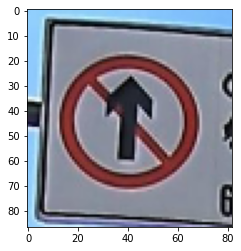

In [ ]:
# here we are checking that our model does prediction right or not
img = plt.imread('/content/drive/MyDrive/Traffic_signal_/infer/10/010_0008_j.png')
plt.imshow(img)
plt.show()

In [ ]:
# # resize image becuase in this size we have train our model
infer_img = cv2.resize(img,(224,224))

In [ ]:
# converting our array to image
x = keras.utils.array_to_img(infer_img)
# it expands the dimention of array like if we have 1D array and we applied expand_dims that convert into 2D array
x = np.expand_dims(x,axis=0)

In [ ]:
# preprocess our image
x = preprocess_input(x)

In [ ]:
# prediction 
final = model.predict(x)

1/1 [==============================] - 0s 57ms/step


In [ ]:
# argmax return the maximum element of the array
traffic=[' Speed limit (5km/h)','Speed limit (15km/h)','Dont Go straight','Dont Go Left','Dont Go Left or Right',' Dont Go Right','Dont overtake from Left','No Uturn','No Car','No horn','Speed limit (40km/h)',' Speed limit (50km/h)','Speed limit (30km/h)','Go straight or right','Go straight','Go Left','Go Left or right','Go Right',' keep Left','keep Right','Roundabout mandatory','watch out for cars','Horn','Speed limit (40km/h)','Bicycles crossing','Uturn','Road Divider','Traffic signals','Danger Ahead','Zebra Crossing','Bicycles crossing','Children crossing','Dangerous curve to the left','Dangerous curve to the right','Speed limit (50km/h)','Unknown1','Unknown2','Unknown3',' Go right or straight',' Go left or straight',' Unknown4','ZigZag Curve','Train Crossing','Under Construction','Unknown5','Speed limit (60km/h)','Fences','Heavy Vehicle Accidents','Unknown6','Give Way','No stopping','No entry','Unknown7','Unknown8','Speed limit (70km/h)','speed limit (80km/h','Dont Go straight or left','Dont Go straight or Right']
predicted = traffic[np.argmax(model.predict(x)[0])]

1/1 [==============================] - 0s 57ms/step


In [ ]:
# model working almost fine
predicted

'Dont Go straight'